# Présentation du modèle de l'équipe MIA

## Résumé

Nous avons choisit de modéliser le modèle sous jacent au signaux par un système LTI. 
Nous ne disposons pas d'une solution explicite de la réponse du système en fontion de l'entrée pour des ordres et des coefficients quelconques. Ainsi, nous utilisons le module $ \it{Scipy} $ pour obtenir une solution approchée. 
Il ne reste plus qu'a choisir un ordre et optimiser les coefficients afin de minimiser l'équart entre la courbe prédite et celle données en exemple. 

## Les systèmes LTI

Un système linéaire et invariant dans le temps (LTI) à une entrée et une sortie peut être décrit mathématiquement par une équation différentielle à coefficient constant liant l'entrée du système et sa sortie. Ainsi, 

$$a_N\frac{d^N y(t)}{dt^N}+\cdots+a_1\frac{d y(t)}{dt}+a_0y(t)=b_N\frac{d^N x(t)}{dt^N}+\cdots+b_1\frac{d x(t)}{dt}+b_0 x(t)$$

où $x(t)$ désigne l'entrée du système et $y(t)$ sa sortie et $N$ correspond à l'ordre du système. Pour analyser ces systèmes, une technique couramment utilisée consiste à passer dans le domaine de Laplace. Notons $X(p)=\mathcal{L}[x(t)]$ et $Y(p)=\mathcal{L}[y(t)]$ les transformées de Laplace de l'entrée et de la sortie. En utilisant le fait que la transformée de Laplace est linéaire et que $\mathcal{L}[\frac{d^k e(t)}{dt^k}]=p^k E(p)$, il est possible de décrire la système par la fonction suivante

$$H(p)\triangleq \frac{Y(p)}{X(p)}=\frac{b_N s^N+b_{N-1}p^{N-1}+\cdots+b_1 p+b_0}{a_N p^N+a_{N-1}p^{N-1}+\cdots+a_1 p+a_0}$$

Cette fonction est appelée **fonction de transfert** du système. D'un point de vue mathématique, à l'exception des systèmes possédant un ordre faible, il est souvent plus pratique d'analyser un système dans le domaine de Laplace plutôt que dans le domaine temporel.

Le langage Python permet de créer des fonctions de transfert via la classe `lti` du module `signal` de Scipy. Cette classe prend deux tableaux en entrée: un tableau contenant les coefficients du numérateur et un tableau contenant les coefficients du dénominateur. 

# Le Modèle en action 

### Initialisation

In [46]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares, minimize

import time
from tqdm import notebook
import importlib

from sklearn.metrics import mean_absolute_error

from numpy import linalg as la

import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

%matplotlib inline

import copy

from sources.utilities.utility_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
model_definition = "model_LTI"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

### Tests unitaires

In [48]:
if sys.platform == "win32":
    #!python sources/utilities/test_submission.py my_model1
    !python sources/utilities/test_submission.py model_LTI
else:
    #!python3 sources/utilities/test_submission.py my_model1
    !python3 sources/utilities/test_submission.py model_LTI

y_pred (50, 5)
Model Description : 
{'affiliation': 'Université Paris-Saclay',
 'description': 'This is a simple LTI model that supports 1 input and 1 to 5 '
                'outputs',
 'email': 'arnaud.gardille@gmail.com',
 'model_name': 'LTI',
 'other_remarks': '',
 'team_name': 'MIA',
 'technology_stack': 'Scipy'}
.
----------------------------------------------------------------------
Ran 1 test in 1.887s

OK


In [49]:
if sys.platform == 'linux':
    !pygmentize "./sources/utilities/model_LTI.py"

In [50]:
rep_data   = "data/DataSet_ex/"
file_train = "input4.csv"

t_train,x_train,y_train = load_data_csv(rep_data+file_train)

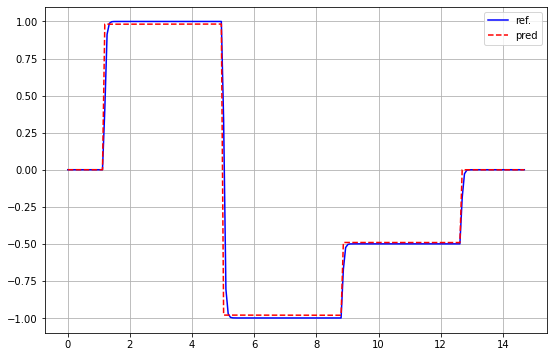

In [51]:
retrain = True

if retrain:
    Ndecim=5
    outputs_indexes = [0]
    model = MyModel.create_model(epochs=150, lr=0.05, output_size = len(outputs_indexes))

    model.fit(xs=[x_train[::Ndecim]],ys=[y_train[::Ndecim,k] for k in outputs_indexes])
    
    retrain = False

y_pred_train = model.predict_timeseries(x_train[::Ndecim])
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_train[::Ndecim],y_train[::Ndecim,outputs_indexes[k]],'b',t_train[::Ndecim],y_pred_train[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

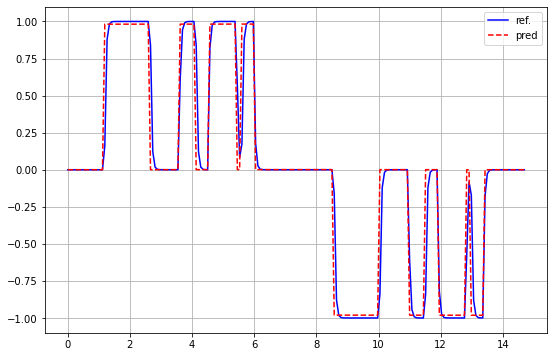

In [52]:
file_test  = "input1.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[::Ndecim,outputs_indexes[k]],'b',t_test[::Ndecim],y_pred[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

## Evaluation

In [53]:
with open("./models/model1/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model1/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [54]:
dHyper,dKwargs

({'model_dir': './models/model1',
  'data_dir': 'data/DataSet_ex/',
  'model_def_file': 'my_model1',
  'epochs': 40,
  'lr': 0.05,
  'outputs_indexes': '1,2,3,4,5',
  'hyper_fileName': 'hyper.json',
  'use_gpu': True,
  'train_fileName': 'input1.csv',
  'Ndecim': 5,
  'outputs_prefix': 'output'},
 {'device': 'cpu', 'epochs': 40, 'lr': 0.05, 'output_size': 5})

In [55]:
model1 = MyModel(**dKwargs)

data_dir = "./data/DataSet_ex"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input2.csv'
model_dir       = './models/model1'
model_def_file  = 'model_LTI'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


with open('./metrics/s2m_GRU2_metrics','r') as f: print(f.read())

# Calcul des coefficients 

Executer tous les codes de la partie Initialisation. 
\
Les parties "Stratégie k" sont indépendantes et peuvent être éxecutées ou non.

### Fonctions de calcul d'une prédiction et de l'erreur

In [56]:

def pred(x, t_e, entree):
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    return (pred(x, t, entree) - y)**2

def err_mean(x, t, entree, y):
    return np.mean(err(x,t,entree,y))

def err_multi(x, times, entrees, outputs):
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def err_multi_ponde(x,times, entrees, outputs, poids):
    error = 0
    for k in range(len(entrees)) :
        error += poids[k]*np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 
    

def RMSE(real,prediction):
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

In [57]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

columns_titles = ['Time','Output1','Input','Output2','Output3','Output4','Output5']

for name in names:
    d[name].columns = columns_titles
    d[name] = d[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]
    
d['input0']

,Time,Input,Output1,Output2,Output3,Output4,Output5
0,0.000,0.0,-2.464122e-07,0.500000,0.500000,1.011923,1.009830
1,0.001,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
2,0.002,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
3,0.003,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
4,0.004,0.0,-2.464121e-07,0.500000,0.500000,1.011923,1.009830
...,...,...,...,...,...,...,...
10231,10.231,0.0,4.889346e-01,0.346165,0.636405,0.603184,1.387077
10232,10.232,0.0,4.874977e-01,0.346696,0.635954,0.604425,1.385976
10233,10.233,0.0,4.860656e-01,0.347225,0.635506,0.605663,1.384878
10234,10.234,0.0,4.846381e-01,0.347751,0.635059,0.606896,1.383784


### Tracé des inputs et des outputs

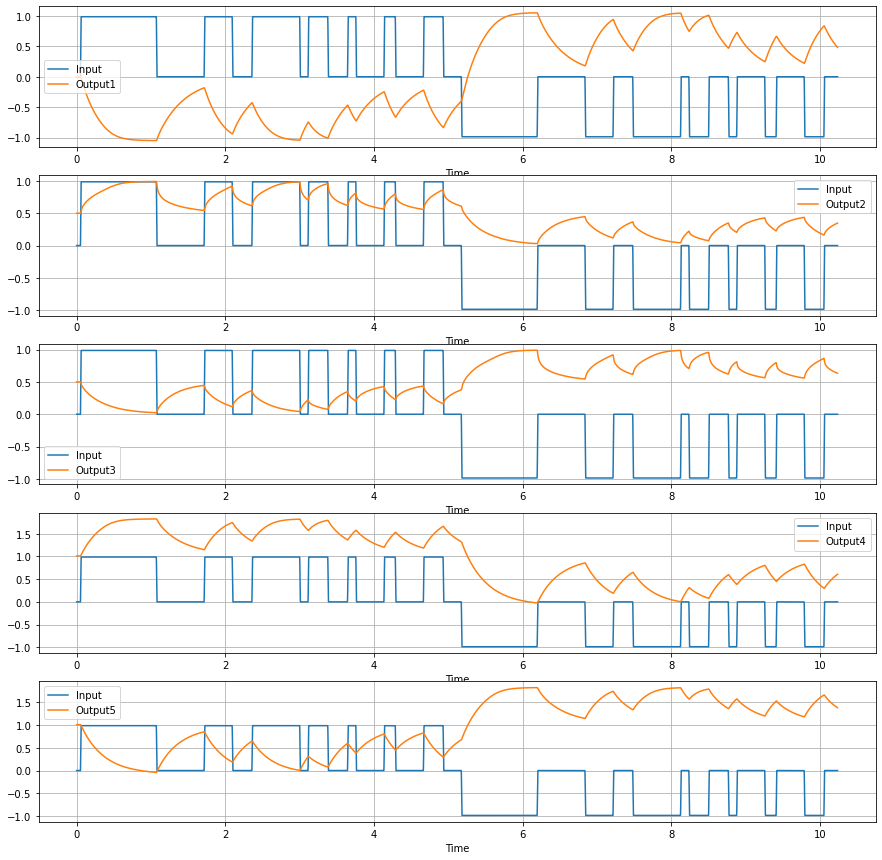

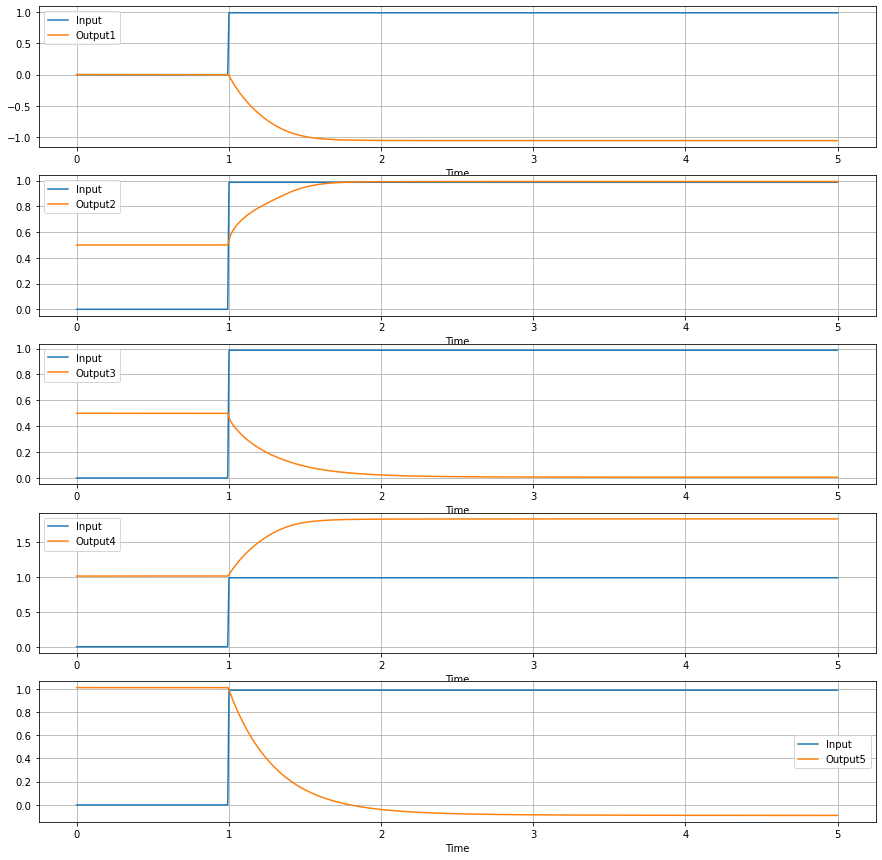

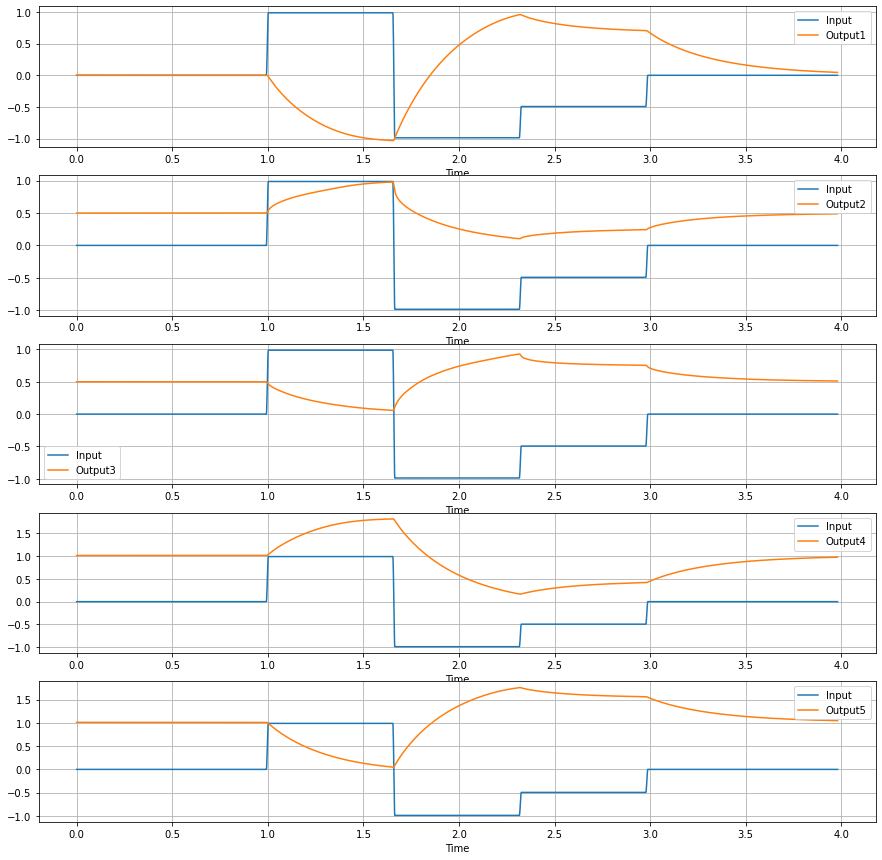

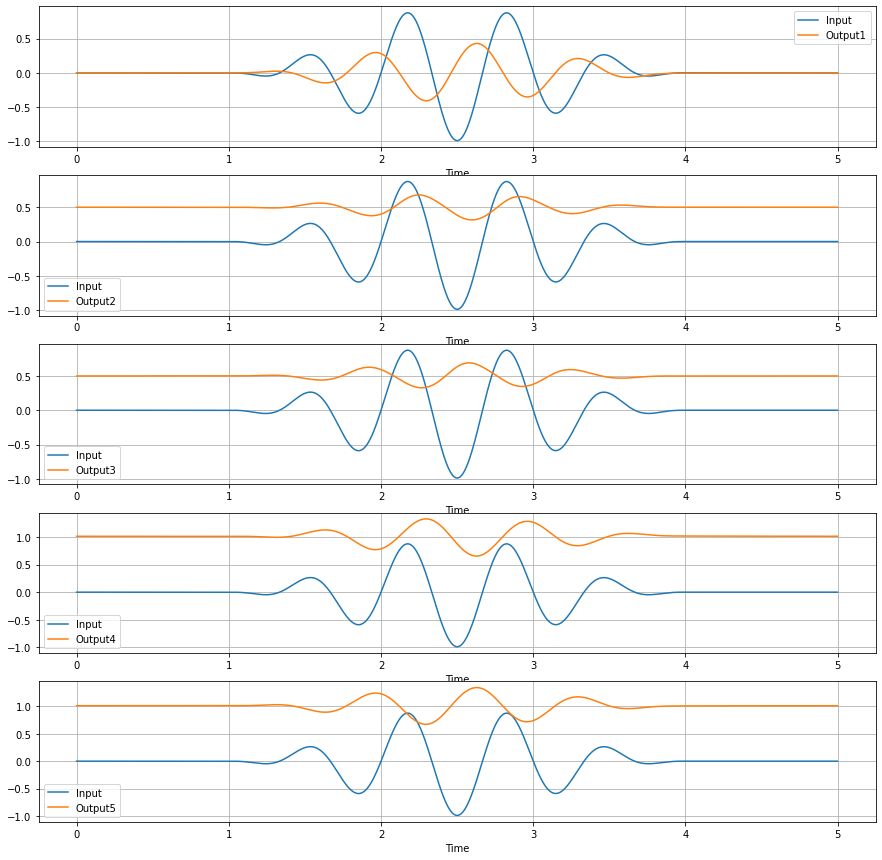

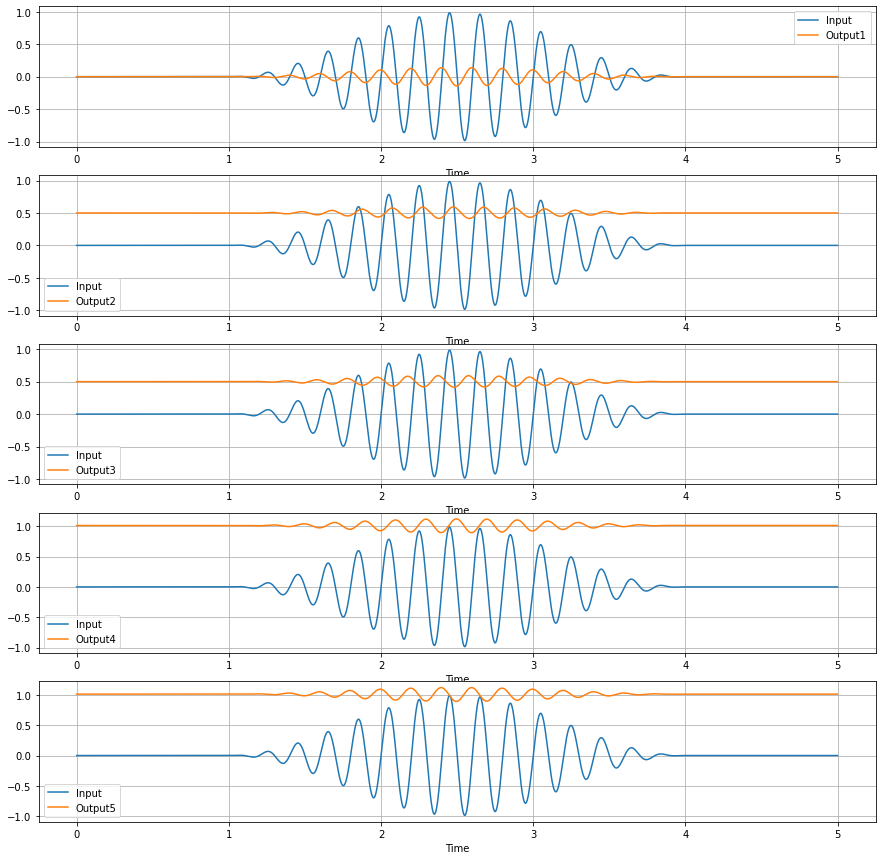

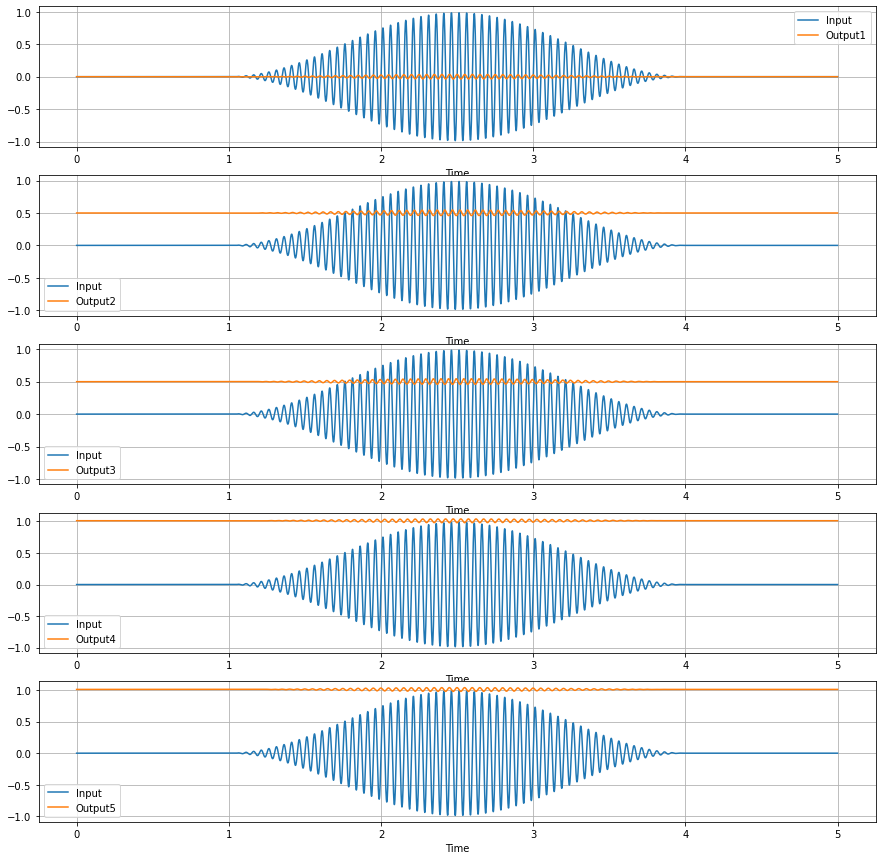

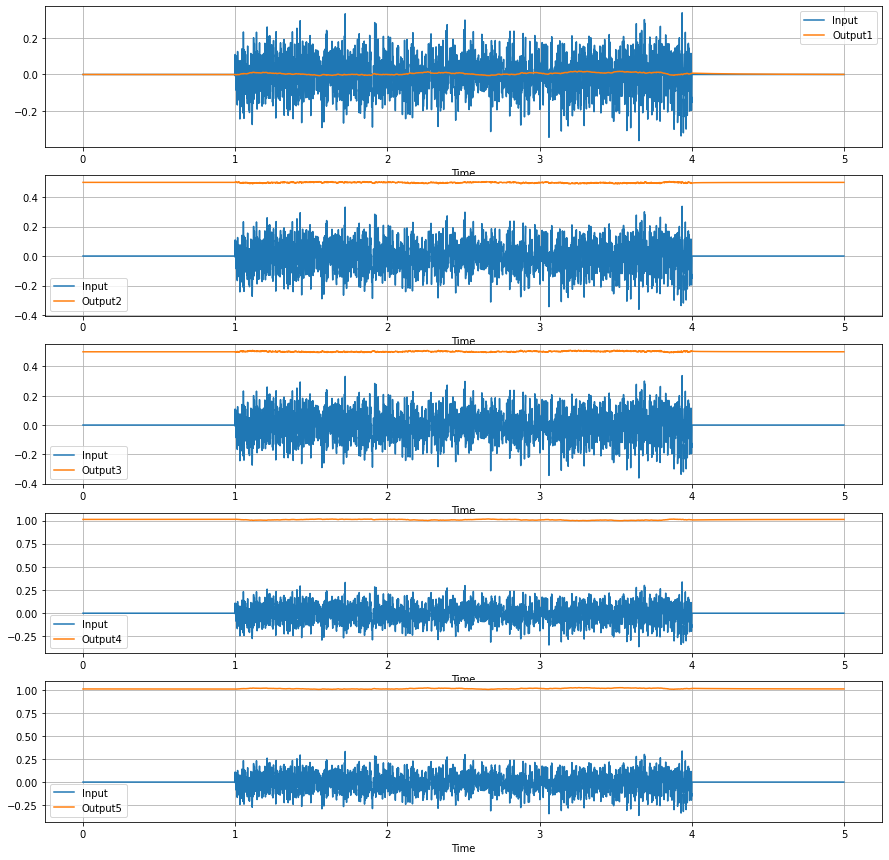

In [58]:


N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

### Calcul des shrink (positif ou négatif) et des offset de chaque output

In [59]:


Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

### Traitement des output

In [60]:

   
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

### Tracé des inputs et des Outputs corrigés


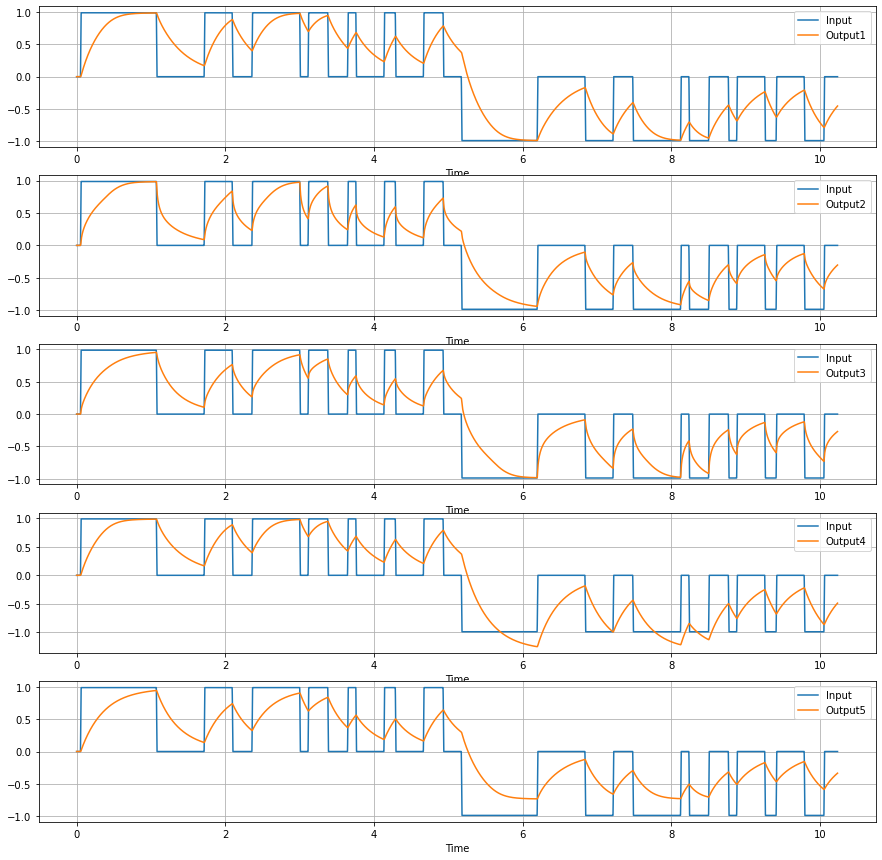

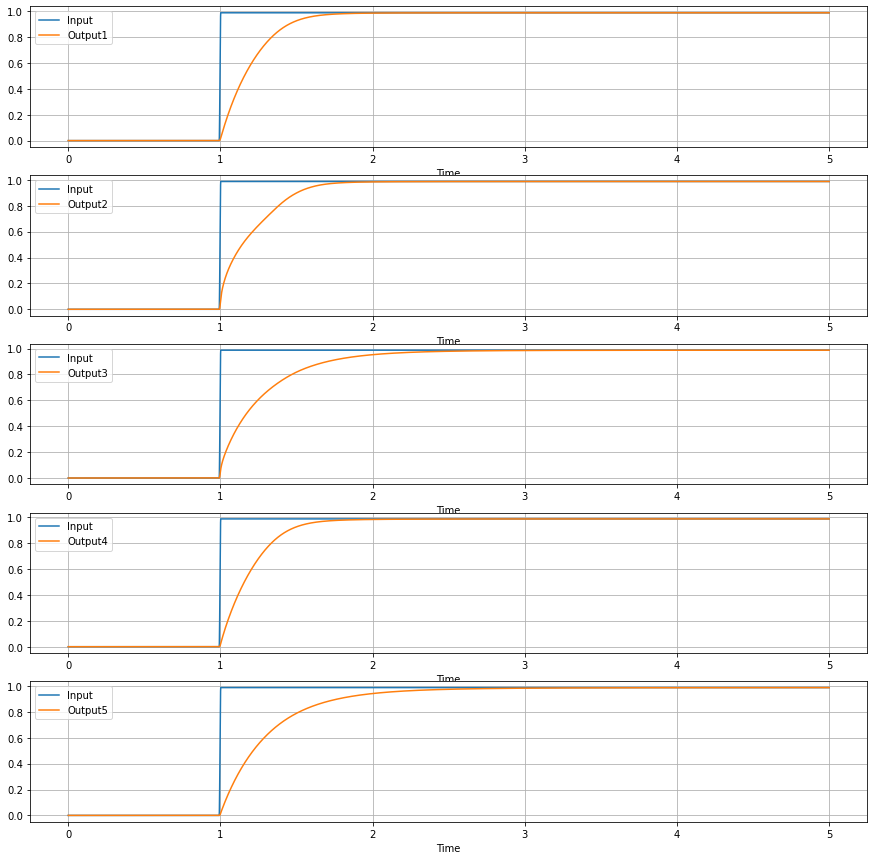

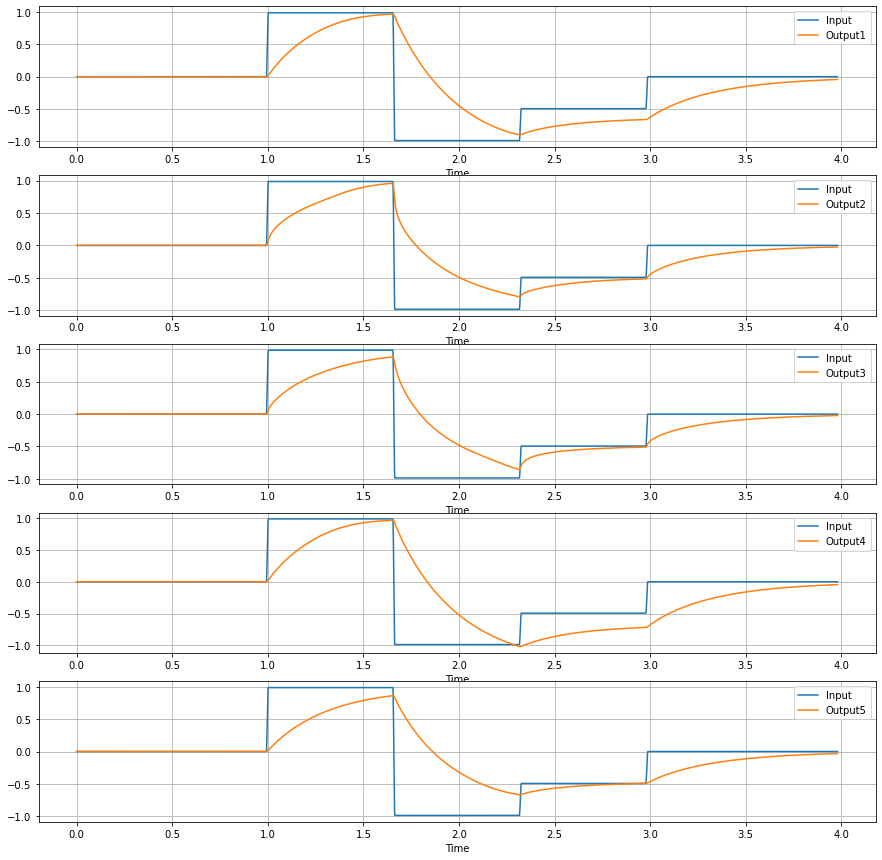

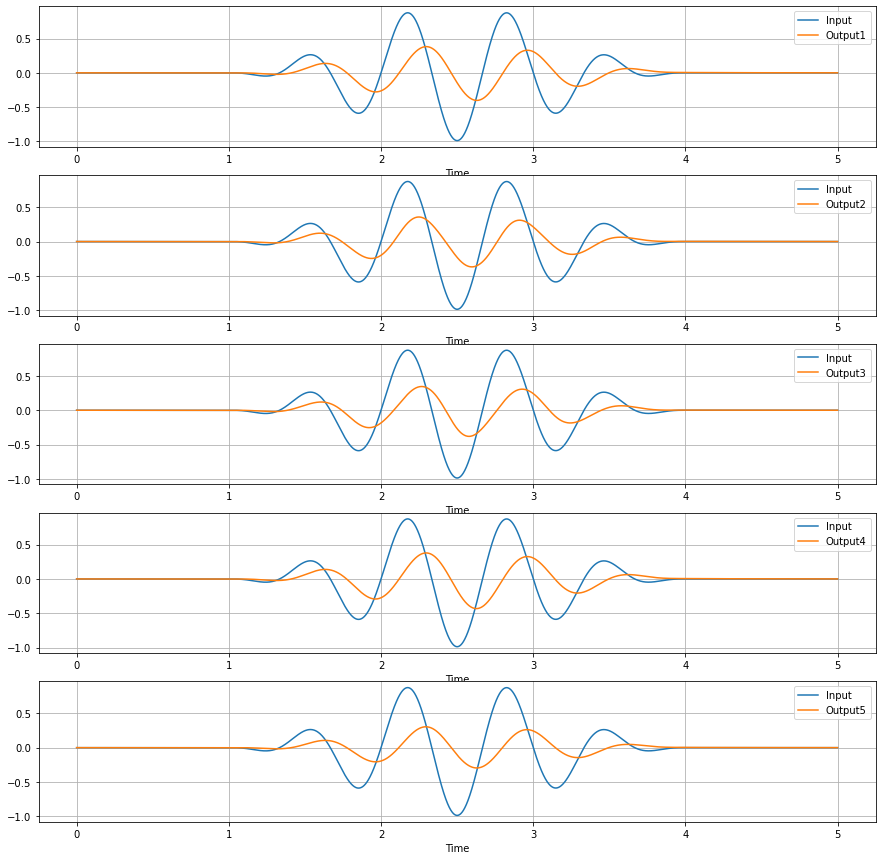

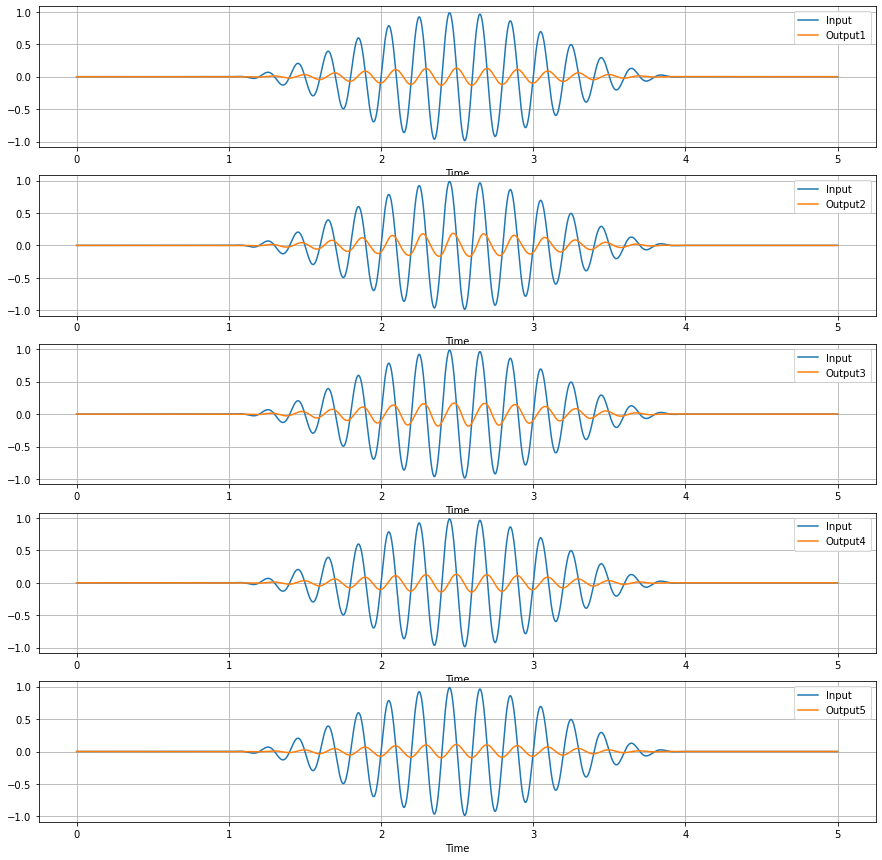

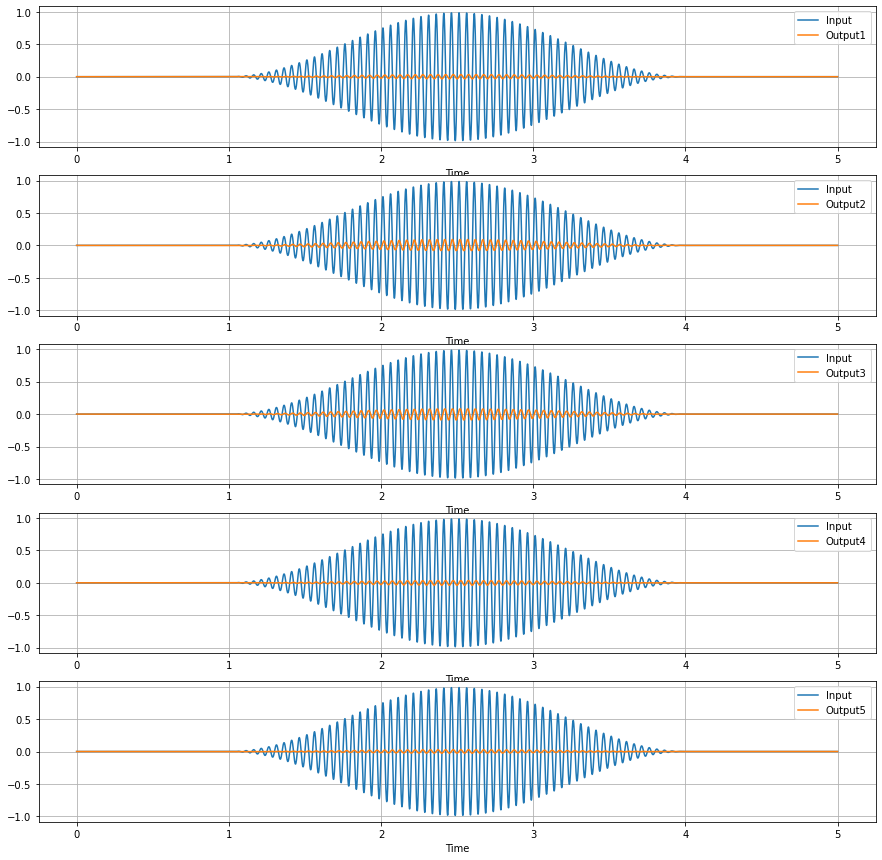

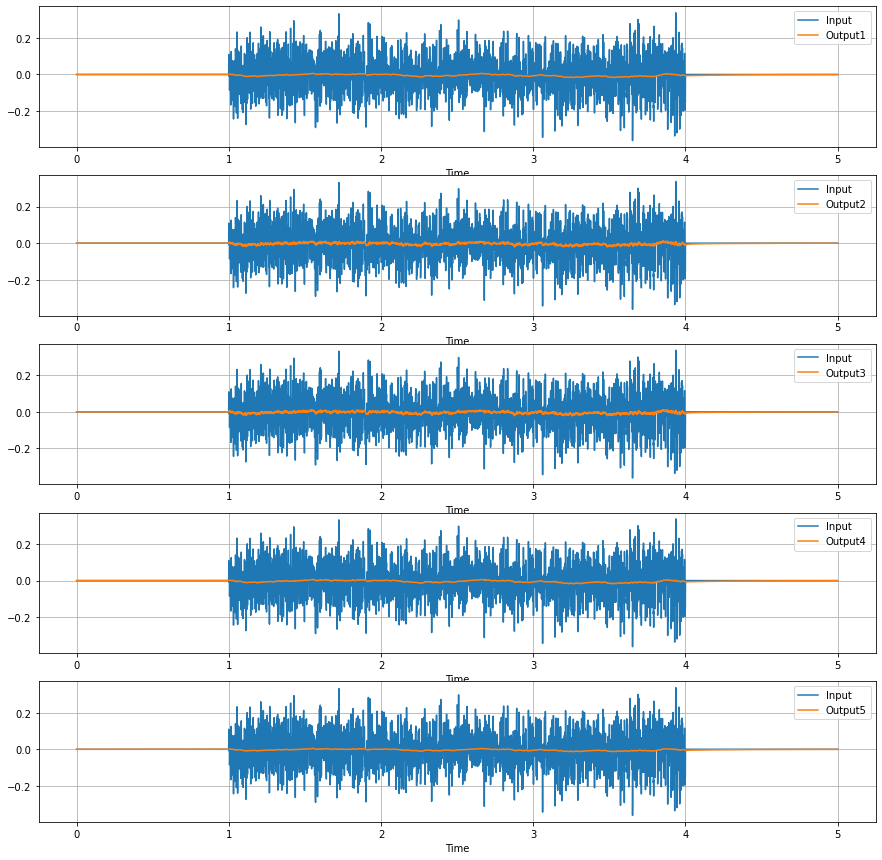

In [61]:

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    _,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

# Stratégie : Moyenne pondérée selon la similitude entre les inputs

Ici on aura des coefficients pour chacun des inputs pour une fonction de transfert donnée (un indice d'output), donc $N_{outputs}\times N_{inputs}$.
\
On définit des paramètres pour classifier les inputs

In [62]:
def calcul_lipschitz(Time,Input):
    max_L = 1
    L = 1
    Time_step = Time[1]-Time[0]
    for k in range(len(Time)-1):
        L = np.abs(Input[k+1]-Input[k])/np.abs(Time_step)
        if L > max_L :
            max_L = L    
    return max_L    



def calcul_changements_signe(Time,Input):
    compteur = 0
    
    for k in range(2,len(Time)):
        if (Input[k]*Input[k-1]<0):
            compteur += 1
            
    return compteur   

In [63]:
def calcul_params_inputs(dic):
    params_inputs = {}
    moyenne_lip = 0
    moyenne_chgmt_signe = 0
    for inp in dic.keys():
        Time = dic[inp]['Time']
        Input = dic[inp]['Input']
        params_inputs[inp] = [] ##[lip,chgmt_signe]
        lip = calcul_lipschitz(Time,Input)
        chgmt_signe = calcul_changements_signe(Time,Input)
        params_inputs[inp].append(lip)
        params_inputs[inp].append(chgmt_signe)
        moyenne_lip += lip/len(dic)
        moyenne_chgmt_signe += chgmt_signe/len(dic)

    ##normalisation des params
    for inp in dic.keys():
        params_inputs[inp][0] = params_inputs[inp][0]/moyenne_lip
        params_inputs[inp][1] = params_inputs[inp][1]/moyenne_chgmt_signe
        
    return params_inputs

### Calcul des paramètres des inputs

In [64]:


inputs = ['input0','input1','input2','input3','input4','input5','input6']
dic = {}
for key in inputs:
    dic[key] = d[key]
params_inputs = calcul_params_inputs(dic)
params_inputs

{'input0': [0.8451886632657197, 0.0],
 'input1': [0.8522461515966162, 0.0],
 'input2': [1.7128667866329361, 0.005083514887436457],
 'input3': [0.05288301884027476, 0.040668119099491654],
 'input4': [0.1811852659053571, 0.14742193173565724],
 'input5': [0.7229540423917611, 0.5998547567175019],
 'input6': [2.6326760713673347, 6.206971677559913]}

### grande similitude : signaux proches

In [65]:
from numpy import linalg as la


def similitude_generale(poids,param1,param2):
    param_1 = np.array(param1)
    param_2 = np.array(param2)
    
    params_dif = param_1-param_2
    params_dif_norme = np.array([np.abs(param) for param in params_dif])
    norme = np.dot(poids,params_dif_norme)
    
    return 1/max([1e-15,norme])

### Coefficients pour chacun des inputs


In [ ]:

inputs = d.keys()

params_output_3 = {}
for name in Output_names : 
    params_output_3[name] = {}
    
degre = 3
N_total = len(Output_names)*len(inputs)
Compteur = 0

for name in Output_names:
    for key in inputs :
        time = d[key]['Time']
        entree = d[key]['Input']
        output = d_corrige[key][name]

        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(time,entree,output), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 80)
        
        ##res = minimize(err_mean, x0, args=(time,entree,output), method = "BFGS")
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")

        params_output_3[name][key] = x

    params_output_3[name] = pd.DataFrame(params_output_3[name])

`xtol` termination condition is satisfied.
Function evaluations 50, initial cost 4.8785e+02, final cost 8.9650e-03, first-order optimality 4.81e-07.
Avancement : 3%
`xtol` termination condition is satisfied.
Function evaluations 57, initial cost 2.6200e+01, final cost 8.7143e-08, first-order optimality 1.45e-09.
Avancement : 6%
`ftol` termination condition is satisfied.
Function evaluations 48, initial cost 5.2238e+02, final cost 1.6359e-04, first-order optimality 4.48e-08.
Avancement : 9%
`xtol` termination condition is satisfied.
Function evaluations 64, initial cost 1.1381e+02, final cost 1.7359e-09, first-order optimality 1.13e-11.
Avancement : 11%
`xtol` termination condition is satisfied.
Function evaluations 65, initial cost 1.4206e+02, final cost 6.6434e-14, first-order optimality 3.21e-14.
Avancement : 14%
`gtol` termination condition is satisfied.
Function evaluations 40, initial cost 1.4607e+02, final cost 4.9019e-16, first-order optimality 6.63e-16.
Avancement : 17%
`xtol` 

In [ ]:
params_output_3

Check des coefficients et suppression des valeurs absurdes/trop mauvaises

### Calcul des outputs approximés

In [ ]:


Sorties_v3_verif = copy.deepcopy(d)

    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    for name in Output_names :
        
        Time = d[key]['Time']
        Input = d[key]['Input']                       
        x = params_output_3[name][key]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
        Sorties_v3_verif[key][name+"_approx"] = sortie
        Sorties_v3_verif[key][name+"_approx"] = pd.DataFrame(Sorties_v3_verif[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")    
    

### Tracé des outputs et des outputs approximés

In [ ]:


N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3_verif[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

On évitera de train sur le bruit dans la suite

### Calcul des output approximés en fonction des autres outputs avec similitude et poids initial 

In [ ]:



inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = np.array([1,1])

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

### Tracé des outputs et des outputs approximés sur l'échantillon de test

In [ ]:


N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

### RMSE pour les signaux de test

In [ ]:


N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0


for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon test : " + str(mean_rmse) )

### Recherche des poids optimaux dans le calcul de similitude


Fonction qui calcule l erreur moyenne globale de la methode similitude

In [ ]:
def erreur_moyenne_simi(poids,inputs,params_output,params_inputs,d):

    for key in inputs:
        for name in Output_names:
            Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))

    N_total = len(Output_names)*len(inputs)
    Compteur = 0

    for key in inputs:
        inputs_train = []
        for inp in inputs:
            if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

        for name in Output_names :
            similitudes_dic = {}
            for key_train in inputs_train:
                time1 = d[key]['Time']
                time2 = d[key_train]['Time']
                time = 0
                if len(time1) > len(time2) : time = time2
                else : time = time1
                similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
            somme = sum(list(similitudes_dic.values()))

            for key_train in inputs_train:
                Time = d[key]['Time']
                Input = d[key]['Input']                       
                x = params_output[name][key_train]
                sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
                Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
            Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
            
    mean_rmse = 0
    N_outputs = 5

    for name in inputs:
        for k in range(N_outputs):
            rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
            mean_rmse += rmse*(name in inputs)/(5*len(inputs))
    
    return mean_rmse

### recherche des poids optimaux dans la similitude

In [ ]:


x0 = np.array([0.5,0.5])
x = np.arange(1,3)
res = least_squares(erreur_moyenne_simi, x0, args=(inputs,params_output_3,params_inputs,d), verbose=2, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 12)
poids_opti = res.x
print(poids_opti)

In [ ]:
poids_opti = [0.08671119,1.01408954]
erreur_moyenne_simi(poids_opti,inputs,params_output_3,params_inputs,d)

### Calcul des output approximés en fonction des autres outputs avec similitude

In [ ]:

inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = poids_opti

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) and (inp != "input6")  : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

### Tracé des outputs et des outputs approximés sur l'échantillon de test

In [ ]:


N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

### MSE pour les signaux de test


In [ ]:

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0
inputs = ['input0','input1','input2','input3','input4','input5','input6']

for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon sauf input0 : " + str(mean_rmse) )